In [1]:
import glob
import json
import pandas as pd
import numpy as np
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.append("./bin")
from ddp_train_resolution import ScaleDataset, ResResNet, resume, args, save
import tqdm

In [2]:
def get_full_image(gt_path):
    full_img_seal_prediction_path = Path(gt_path).parent().with_name(p.name.split('.')[0]).with_suffix(".seals.pred.json")
    d = json.load(open(full_img_seal_prediction_path, "r").read()) # reading from the json in order to avoid loadin the image
    img_path = glob.glob(f"{full_img_seal_prediction_path.replace('.seals.pred.json','.img.*')}")[0]
    return d["image_wh"], img_path
    

In [3]:
#all_gt_files = glob.glob("data/1000_CVCharters/*/*/*/*.crops/*.resolution.gt.json")
#print(all_gt_files[0])
#!cat ../1000_CVCharters/AT-StiAHe/a1bdd45f2b4bf61d31603123cb316526/f62d5e17562bf731b59658ff8cb9a8a5/0fadaa51377c126b9373da1daf209310.seals.crops/4.resolution.gt.json



data/1000_CVCharters/AT-StiAHe/a1bdd45f2b4bf61d31603123cb316526/f62d5e17562bf731b59658ff8cb9a8a5/0fadaa51377c126b9373da1daf209310.seals.crops/4.resolution.gt.json


In [10]:
model = ResResNet()
hist = {"train": [], "val": [], arg_hist={}}
epoch = 0
#save(args.resume_path, model, epoch, hist)
model, epoch, hist, arg_hist = resume(args.resume_path, model, args.device)

writeable_area_dataset = ScaleDataset()

In [ ]:
resolution_gt_glob="../../1000_CVCharters/*/*/*/*.seals.crops/*.resolution.gt.json"
resolution_gt_list = list(sorted(glob.glob(resolution_gt_glob)))
train_resolution_gt_list = resolution_gt_list[100:]
val_resolution_gt_list = resolution_gt_list[:100]

writable_glob_subtuple = ("[0-9]+\.resolution\.gt\.json", "*.Img_WritableArea.jpg")
seal_glob_subtuple = ("[0-9]+\.resolution\.gt\.json", "*.Img_Seal.jpg")
calibration_glob_subtuple = ("[0-9]+\.resolution\.gt\.json", "*.Img_CalibrationCard.jpg")

train_writable_ds = ScaleDataset(resolution_gt_list=train_resolution_gt_list, input_glob_subtuple=writable_glob_subtuple)
val_writable_ds = ScaleDataset(resolution_gt_list=val_resolution_gt_list, input_glob_subtuple=writable_glob_subtuple)

train_seal_ds = ScaleDataset(resolution_gt_list=train_resolution_gt_list, input_glob_subtuple=writable_glob_subtuple)
val_writable_ds = ScaleDataset(resolution_gt_list=val_resolution_gt_list, input_glob_subtuple=writable_glob_subtuple)


In [5]:
all_ppcm = []
all_crude_ppcm = []
for gt_file in all_gt_files:
    ppcm, crude_ppcm = ScaleDataset.analyse_card(gt_file)
    all_ppcm.append(ppcm)
    all_crude_ppcm.append(crude_ppcm)

data = pd.DataFrame(data={"PPCM":all_ppcm, "CRUDE_PPCM": all_crude_ppcm})

data

,PPCM,CRUDE_PPCM
0,72.000278,73.743842
1,72.002500,73.054187
2,71.201124,71.428571
3,43.400461,45.320197
4,82.800242,29.458128
...,...,...
510,71.202528,73.940887
511,51.800386,54.137931
512,51.601550,54.088670
513,156.003205,159.556650


/home/anguelos/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,PPCM,CRUDE_PPCM
PPCM,1.000000,0.632182
CRUDE_PPCM,0.632182,1.000000


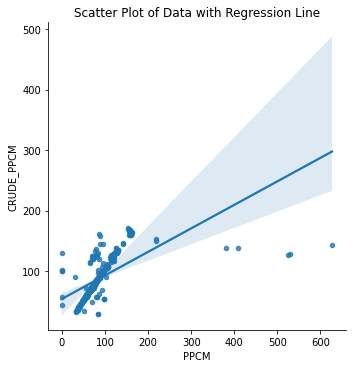

In [6]:
#ax1 = data.plot.scatter(x='PPCM',y='CRUDE_PPCM',c='DarkBlue')

sns.lmplot('PPCM', 'CRUDE_PPCM', data=data, fit_reg=True, scatter_kws={"marker": "D", "s": 20})
plt.title('Scatter Plot of Data with Regression Line')
plt.xlabel('PPCM')
plt.ylabel('CRUDE_PPCM')
data.corr()

39.193897305247965


/home/anguelos/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,PPCM,CRUDE_PPCM
PPCM,1.000000,0.922386
CRUDE_PPCM,0.922386,1.000000


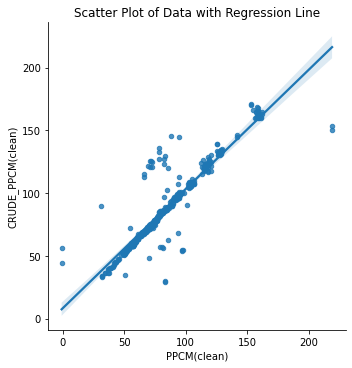

In [8]:
dif = (data["PPCM"] - data["CRUDE_PPCM"])**2
print(sorted(dif.tolist())[int(.85*len(dif))])
clean_data = data[dif<sorted(dif.tolist())[int(.98*len(dif))]]
clean_data

sns.lmplot('PPCM', 'CRUDE_PPCM', data=clean_data, fit_reg=True, scatter_kws={"marker": "D", "s": 20})
plt.title('Scatter Plot of Data with Regression Line')
plt.xlabel('PPCM(clean)')
plt.ylabel('CRUDE_PPCM(clean)')
clean_data.corr()

#for thr in range(1,21):
#    pass